
#  **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


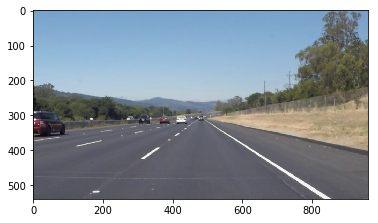

In [27]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
#print(image[0:4, 0:4, :])
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [45]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
   
            
def average_lines(lines):
    
    # weights to improve results
    r_lanes = [] # ( slope, intercept)
    r_weights = []
    
    l_lanes = []
    l_weights = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 != x2:
                slope = ((y2-y1)/(x2-x1))
                if slope > 0 and slope != 0 : # right lane, x axis going down and y going to the right                    
                    intercept = y2 - slope*x2
                    r_lanes.append((slope, intercept))                                   
                    r_weights.append(np.sqrt((y2-y1)**2 + (x2-x1)**2 ))
                    
                elif slope < 0 and slope != 0: # left lane                    
                    intercept = y2 - slope*x2
                    l_lanes.append((slope, intercept))
                    l_weights.append(np.sqrt((y2-y1)**2 + (x2-x1)**2 ))
                            

    # Weigthed average
    r_lane = np.dot(r_weights, r_lanes) / np.sum(r_weights) if len(r_weights) > 0 else None
    
    l_lane = np.dot(l_weights, l_lanes) / np.sum(l_weights) if len(l_weights) > 0 else None
    
    return l_lane, r_lane
    
    

# For video, I noticed that for some frames, the lanes were not deteced.
# A solution is to use the average of the previous lanes.
# This will obviously not worked for quick changes of direction
r_lanes = []
l_lanes = []
def draw_lines(img, r_lane, l_lane, video=False, color=[255, 0, 0], thickness=20):
    
    """
    In case of videos, store the previous lanes, up to 10
    """
    if video:
        if l_lane is not None:
            l_lanes.append(l_lane)
            # keep only the last 10
            if len(l_lanes) > 10:
                l_lanes.pop(0)
        if r_lane is not None:
            r_lanes.append(r_lane)
            # keep only the last 10
            if len(r_lanes) > 10:
                r_lanes.pop(0)
        l_lane = np.mean(l_lanes, axis = 0)
        r_lane = np.mean(r_lanes, axis = 0)
    
    # Generate start and end points
    rows, cols = img.shape[:2]
    
    
    if l_lane is None or r_lane is None:
        return 
        
    # Right lane
    r_y1 = rows
    r_x1 = int((r_y1 - r_lane[1])/r_lane[0])
    r_y2 = int(rows*.7)
    r_x2 = int((r_y2 - r_lane[1])/r_lane[0])

    # Left lane
    l_y1 = rows    
    l_x1 = int((l_y1 - l_lane[1])/l_lane[0])

    l_y2 = int(rows*.7)
    l_x2 = int((l_y2 - l_lane[1])/l_lane[0])

    pts_left = np.array([[l_x1, l_y1], [l_x2, l_y2]])
    pts_right = np.array([[r_x1, r_y1], [r_x2, r_y2]])
    pts = np.array([[[l_x2, l_y2], [l_x1, l_y1], [r_x1, r_y1], [r_x2, r_y2]]])


    cv2.fillPoly(img, [pts], (0,255, 0))
    cv2.polylines(img, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
    cv2.polylines(img, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)

    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Printout Images

In [65]:
import os
path = "test_images/"
images_filenames = os.listdir(path)

In [68]:
# To show images
def plt_images(images, cmap=None):
    cols = 3
    rows = (len(images))//cols if len(images) % cols == 0 else len(images)//cols + 1
    
    plt.figure(figsize=(30, 16))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

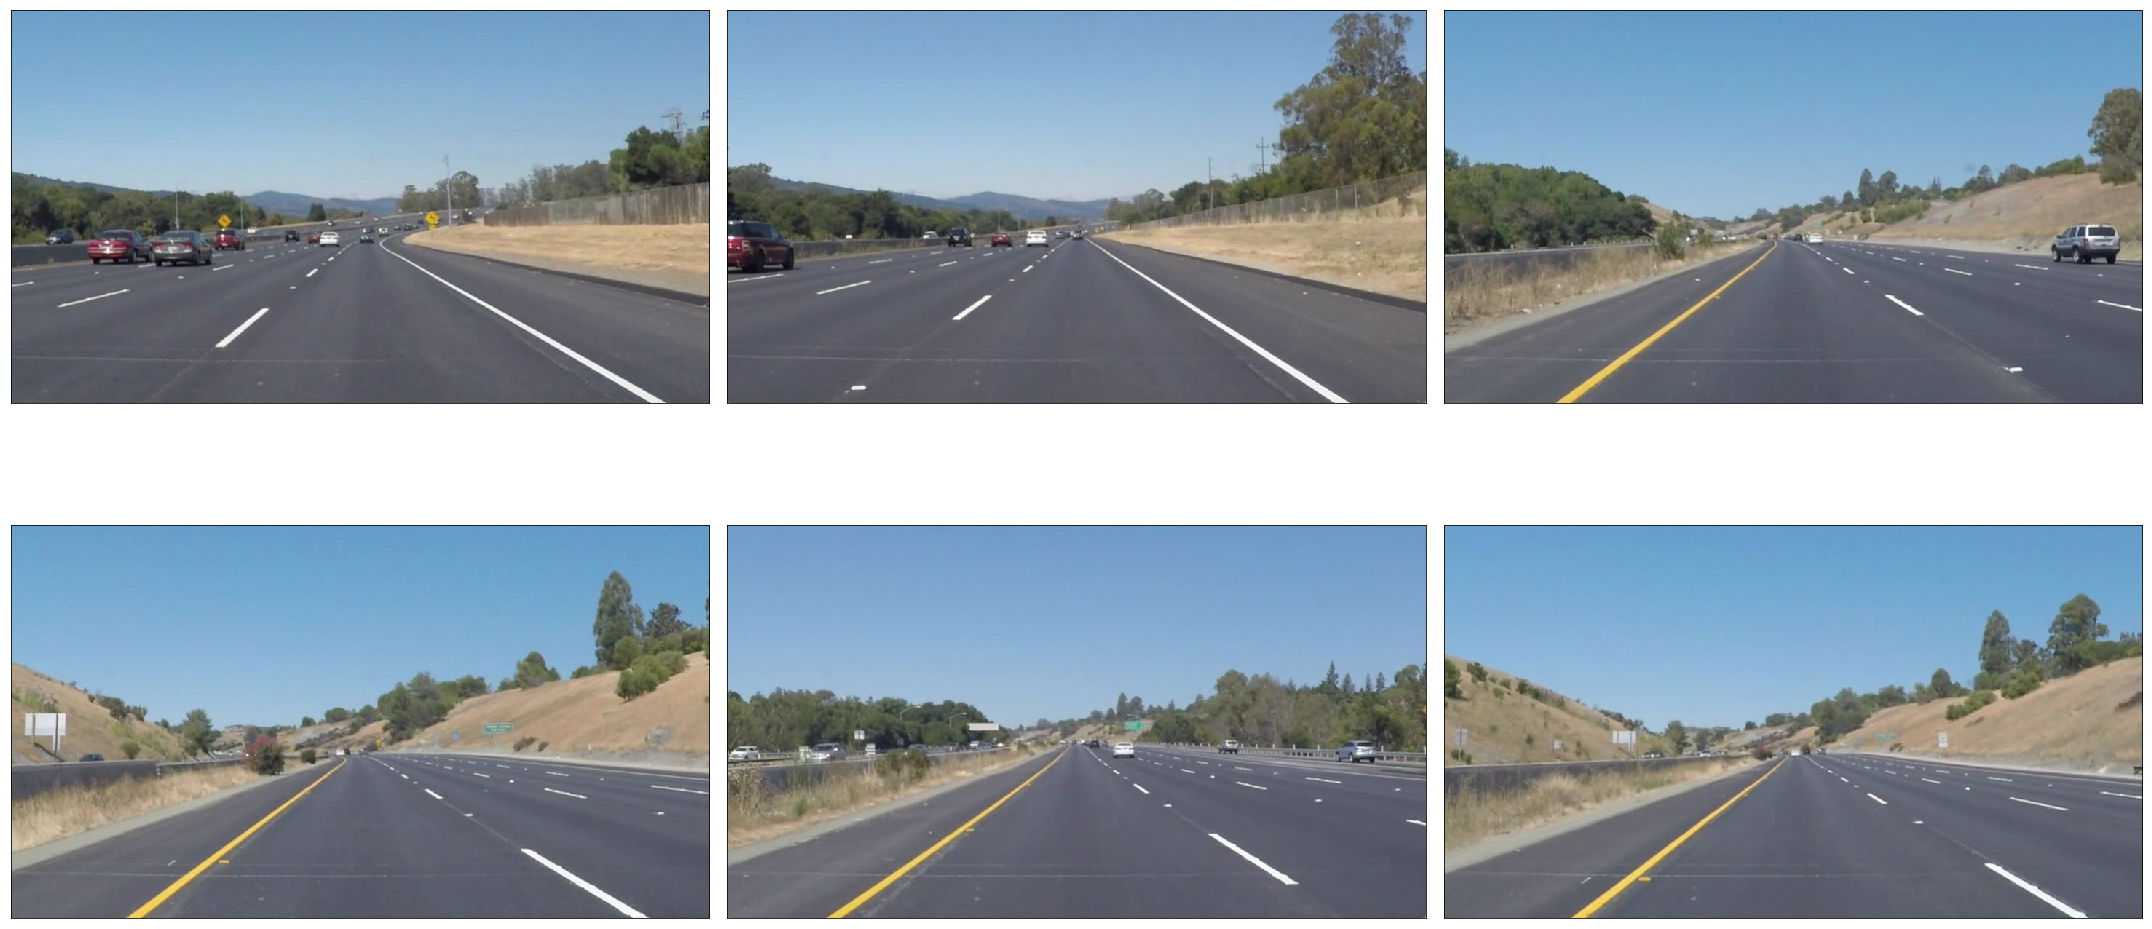

In [69]:
test_images = [mpimg.imread(path + images_filenames[i]) for i in range(len(images_filenames))]    
plt_images(test_images)

From the test images, one can see that the lanes lines colours are white and yellow. So selecting the colors in the images, as a preprocessing step,  is a good idea.
The following steps are:
* Grayscale
* Gaussian Blur 
* Canny
* Hough Lines

## Build a Lane Finding Pipeline



In [50]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# colors selection 
# yellow, white
def rgb_yellow_white_filter(img):
        
    lower = np.uint8([190, 190, 0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    
    lower = np.uint8([210, 210, 210])
    upper = np.uint8([255, 255, 255])
    
    white_mask = cv2.inRange(img, lower, upper)        
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    output = cv2.bitwise_and(img, img, mask = mask)    

    return output

# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(image, sigma=0.33):
    
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return [lower, upper]

def find_lane(img, video=False):
    
    img_copy = img.copy()
    img_copy = rgb_yellow_white_filter(img_copy)
    img_copy = grayscale(img_copy) 
    img_copy = gaussian_blur(img_copy, 5)
    thresholds = auto_canny(img)
    img_copy = canny(img_copy, thresholds[0], thresholds[1])
        
    # Region of interest
    # ROI is a polygon     
    rows, cols = image.shape[:2]
    bottom_left  = [0, rows]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols, rows]
    top_right    = [cols*0.6, rows*0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    img_copy = region_of_interest(img_copy, vertices)
    
    # Hough Line transformation 
    lines = hough_lines(img_copy, 1, np.pi/180, 50, 30, 150)
    l_lane, r_lane = average_lines(lines)
    img_copy = np.zeros((img_copy.shape[0], img_copy.shape[1], 3), dtype=np.uint8)
    
    draw_lines(img_copy, r_lane, l_lane, video)
    
    # weigthed image
    img_copy = weighted_img(img, img_copy)
    return img_copy

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

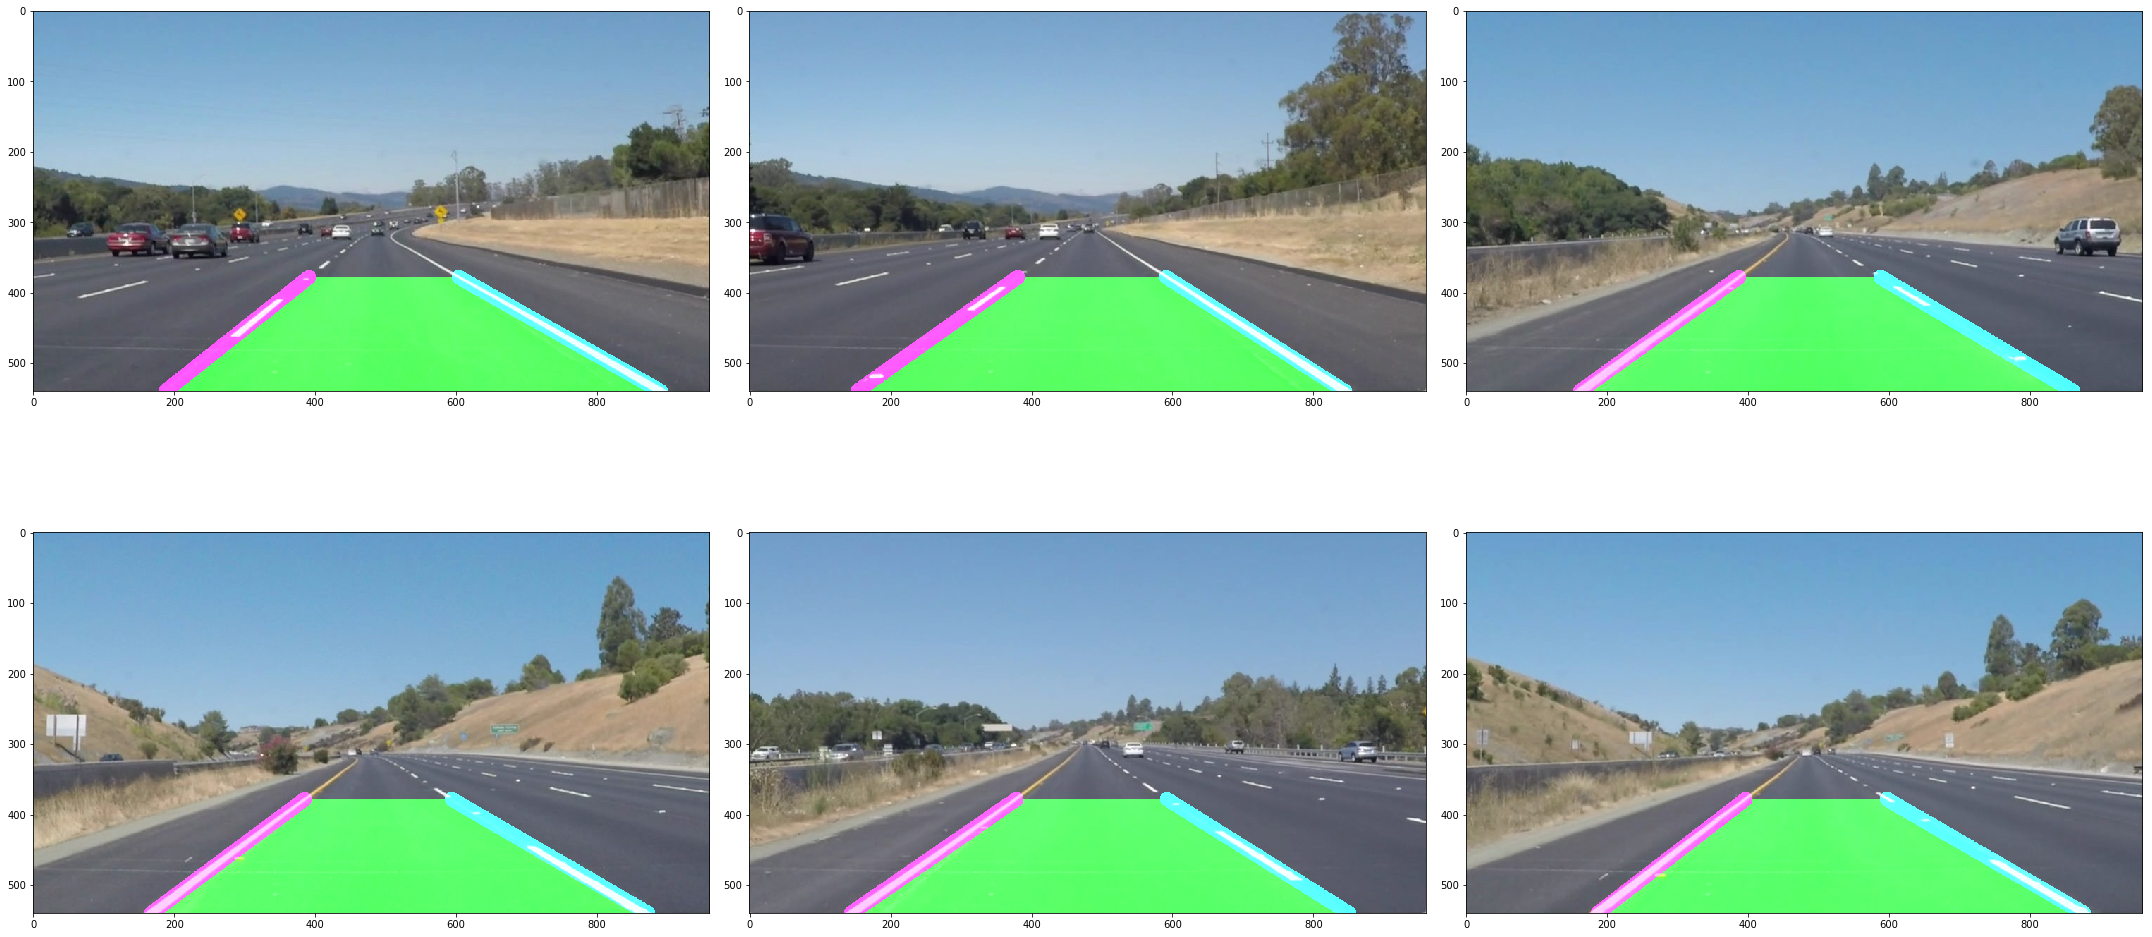

In [51]:
test_images_output = list(map(find_lane, test_images))
output_path = "test_images_output/"
for i, image in enumerate(test_images_output):
    cv2.imwrite(output_path+images_filenames[i], image)
plt_images(test_images_output)

## Test on Videos


In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = find_lane(image, True)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [52]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
white_clip.reader.close()
white_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:12<00:00, 17.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 14.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [63]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)
yellow_clip.reader.close()
yellow_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:34<00:00, 19.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 36.2 s


In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [60]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:37<00:00, 19.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 38.8 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflection

The goal of the project was to build a pipeline to dectect the lanes road.

### 1. Pipeline

The pipeline consisted of five steps.
After plotting out the images, the lanes road lines colors were identified.
* So the first step was to filter the lanes road colors.
On the tests images and videos, the yellow and white filter does not show better improvement. Therefore, this step could be removed. 
* Then, I applied grascale, then a gaussian filter to remove the noise and blur the image.
* The canny edge detector was applied with thresholds found using code at [link](https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
). 
* The next step was the Hough line function. 
* To improve draw_lines, I used an average method. I computed the average slope and intercept on left and right lanes. I chose the y values: the bottom images and the middle of images. With the y values, slopes and intercepts, I was able to find the x values associated. For the videos tests, I had to modify the functions as for some frame, no lanes were found. The video was then jittery. I used an average of the previous frames lanes for the current video frame if none was found. Otherwise, the lane of the frame was the average of all previous frames lanes.

### 2. Shortcomings 
* I think this pipeline would not work with curvy lanes roads as the lanes are drawn by averaging lines.
* Also, when tried on the optional challenge, the pipeline did not work under the shadow.

### 3. Improvements
* A better color filter (filter in other color space) would improve the accuracy
* A better model for detecting the road (instead of lines, curves)